In [2]:
from pathlib import Path

import pandas as pd
from matplotlib import pyplot as plt
from pandas import DataFrame

from caveat.evaluate.describe import transitions
from caveat.evaluate.describe.frequency import frequency_plots
from caveat.evaluate.describe.times import (
    joint_time_distributions_plot,
    times_distributions_plot,
)
from caveat.evaluate.describe.transitions import sequence_prob_plot

In [3]:
cmap = {
    "home": (0.5529411764705883, 0.8274509803921568, 0.7803921568627451),
    "other": (1.0, 1.0, 0.7019607843137254),
    "shop": (0.7450980392156863, 0.7294117647058823, 0.8549019607843137),
    "work": (0.984313725490196, 0.5019607843137255, 0.4470588235294118),
    "escort": (0.5019607843137255, 0.6941176470588235, 0.8274509803921568),
    "visit": (0.9921568627450981, 0.7058823529411765, 0.3843137254901961),
    "education": (0.7019607843137254, 0.8705882352941177, 0.4117647058823529),
    "medical": (0.9882352941176471, 0.803921568627451, 0.8980392156862745),
    "travel": (0.8509803921568627, 0.8509803921568627, 0.8509803921568627),
}


batch_paths = {
    "CVAE": Path("../logs/cvaes/CVAE"),
    "Add": Path("../logs/cvaes/Add"),
    "Feed": Path("../logs/cvaes/Feed"),
    "After": Path("../logs/cvaes/After"),
    "All": Path("../logs/cvaes/All"),
    "Nudge": Path("../logs/cvaes/Nudge"),
    "DoubleNudge": Path("../logs/cvaes/DoubleNudge"),
    "NudgeAdv": Path("../logs/cvaes/NudgeAdv"),
}

# find data
target_schedules = pd.read_csv("../tmp/nts_home_schedules.csv")
acts = list(target_schedules.act.value_counts(ascending=False).index)
class_map = {n: i for i, n in enumerate(acts)}

target_attributes = pd.read_csv("../tmp/nts_home_attributes_groups.csv")


def latest(path: Path):
    versions = sorted(
        [
            d
            for d in path.iterdir()
            if d.is_dir() and d.name.startswith("version")
        ]
    )
    return path.name, versions[-1]


def iter_models(path: Path):
    for dir in path.iterdir():

        if dir.is_dir():

            yield latest(dir)


def find_nth(path: Path, n=0):

    ranks = (
        pd.read_csv(path / "domain_distances.csv")
        .drop(columns=["domain", "observed", "mean", "std"], errors="ignore")
        .rank(axis=1, method="min")
        .sum(axis=0)
    )
    ranked = [i for _, i in sorted(zip(ranks, ranks.index))]
    top = ranked[n]
    dir = path / top
    yield latest(dir)


def load_attributes(path: Path, default=None):
    if (path / "synthetic_attributes.csv").exists():
        print(f"Loading synthetic attributes from {path}")
        return pd.read_csv(path / "synthetic_attributes.csv")
    if (path / "synthetic_labels.csv").exists():
        print(f"Loading synthetic labels from {path}")
        return pd.read_csv(path / "synthetic_labels.csv")
    print(f"Failed to find attributes at {path}")
    return default

In [4]:
schedules = {
    n: pd.read_csv(latest(p)[1] / "synthetic_schedules.csv")
    for n, p in batch_paths.items()
}
attributes = {
    n: load_attributes(latest(p)[1], default=target_attributes)
    for n, p in batch_paths.items()
}

Loading synthetic attributes from ..\logs\cvaes\CVAE\version_0
Loading synthetic attributes from ..\logs\cvaes\Add\version_0
Loading synthetic attributes from ..\logs\cvaes\Feed\version_0
Loading synthetic attributes from ..\logs\cvaes\After\version_0
Loading synthetic attributes from ..\logs\cvaes\All\version_0
Loading synthetic attributes from ..\logs\cvaes\Nudge\version_0
Loading synthetic attributes from ..\logs\cvaes\DoubleNudge\version_0
Loading synthetic attributes from ..\logs\cvaes\NudgeAdv\version_0


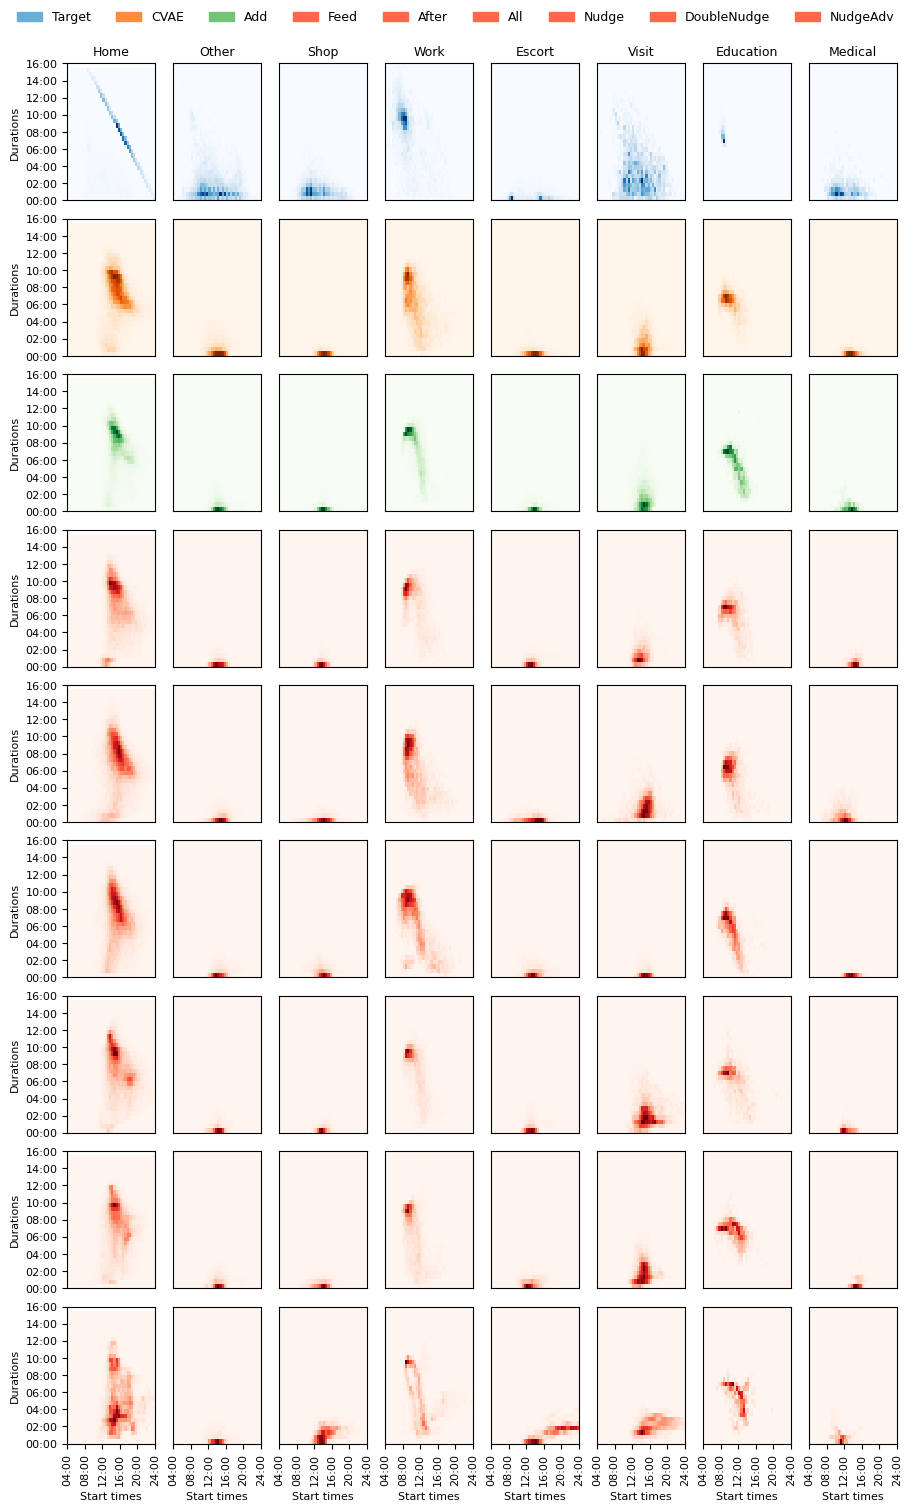

In [17]:
fig = joint_time_distributions_plot(
    target_schedules,
    schedules,
    figsize=(9, 15),
    observed_title="Target",
    cmaps={0: "Blues", 1: "Oranges", 2: "Greens", 3: "Reds"},
)

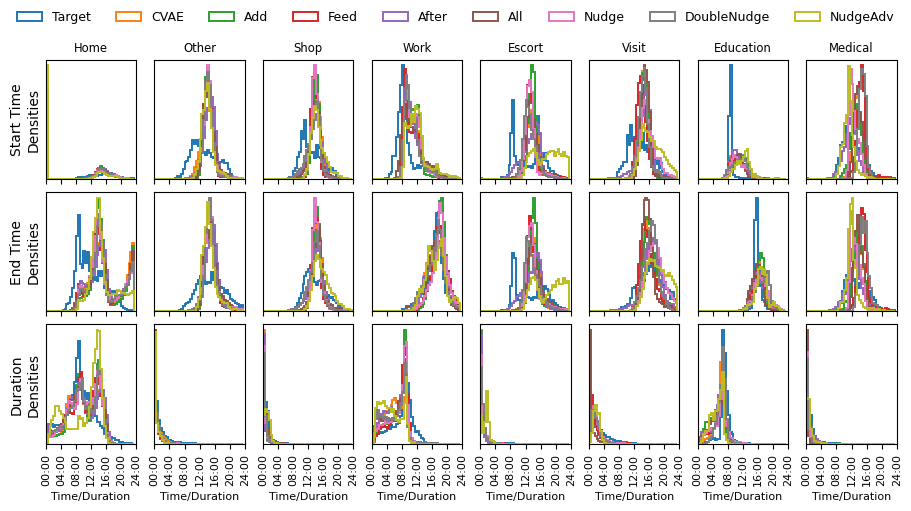

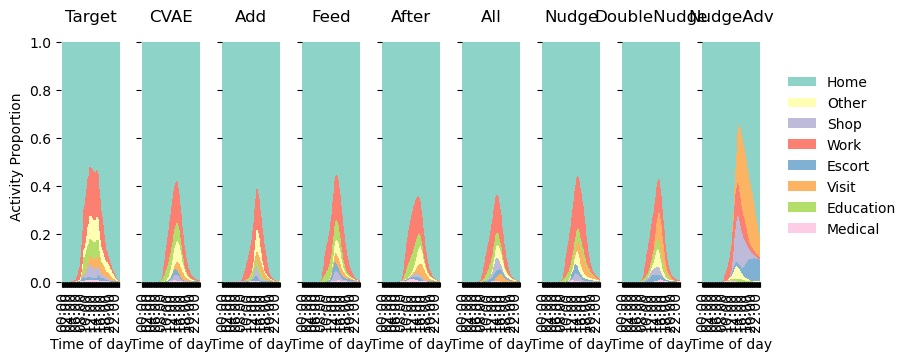

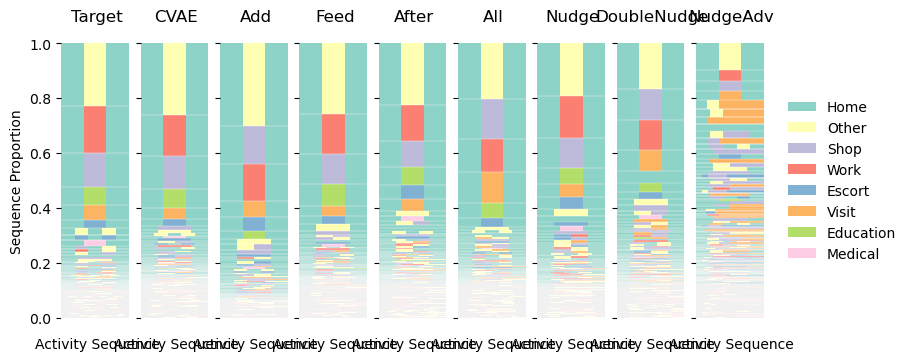

In [6]:
fig = times_distributions_plot(
    target_schedules, schedules, observed_title="Target", figsize=(9, 5)
)
fig = frequency_plots(
    target_schedules,
    schedules,
    color=cmap,
    figsize=(9, 3.5),
    observed_title="Target",
)
fig = sequence_prob_plot(
    target_schedules,
    schedules,
    cmap=cmap,
    figsize=(9, 3.5),
    observed_title="Target",
)

In [7]:
import random

from pam.core import Household, Person
from pam.plot.plans import plot_household

from caveat.data.utils import trace_to_pam


def stretch(schedules):
    return schedules.groupby(schedules.pid).apply(stretcher)


def stretcher(schedule):
    duration = schedule.duration.sum()
    if duration != 1440:
        a = 1440 / duration
        schedule.duration = (schedule.duration * a).astype(int)
        accumulated = list(schedule.duration.cumsum())
        schedule.start = [0] + accumulated[:-1]
        schedule.end = accumulated
    return schedule


def trim(schedules):
    schedules[schedules.end > 1440] = 1440
    schedules[schedules.start > 1440] = 1440
    schedules.duration = schedules.end - schedules.start
    schedules = schedules[schedules.duration > 0]
    return schedules


def pad(schedules):
    return (
        schedules.groupby(schedules["pid"]).apply(padder).reset_index(drop=True)
    )


def padder(schedule):
    if schedule.end.iloc[-1] < 1440 and schedule.act.iloc[-1] != "home":
        pid = schedule.pid.iloc[0]
        schedule = pd.concat(
            [
                schedule,
                DataFrame(
                    {
                        "pid": pid,
                        "start": schedule.end.iloc[-1],
                        "end": 1440,
                        "duration": 1440 - schedule.end.iloc[-1],
                        "act": "home",
                    },
                    index=[0],
                ),
            ]
        )
    elif schedule.end.iloc[-1] < 1440:
        schedule.end.iloc[-1] = 1440
        schedule.duration.iloc[-1] = 1440 - schedule.start.iloc[-1]
    return schedule


def plot_schedules(schedules, **kwargs):

    cmap = {
        "home": (0.5529411764705883, 0.8274509803921568, 0.7803921568627451),
        "other": (1.0, 1.0, 0.7019607843137254),
        "shop": (0.7450980392156863, 0.7294117647058823, 0.8549019607843137),
        "work": (0.984313725490196, 0.5019607843137255, 0.4470588235294118),
        "escort": (0.5019607843137255, 0.6941176470588235, 0.8274509803921568),
        "visit": (0.9921568627450981, 0.7058823529411765, 0.3843137254901961),
        "education": (
            0.7019607843137254,
            0.8705882352941177,
            0.4117647058823529,
        ),
        "medical": (0.9882352941176471, 0.803921568627451, 0.8980392156862745),
        "travel": (0.8509803921568627, 0.8509803921568627, 0.8509803921568627),
    }
    cmap = {n.title(): c for n, c in cmap.items()}

    hh = Household("")

    pids = schedules.pid
    selected = random.sample(list(pids), 5)
    for i, pid in enumerate(selected):
        person = Person(pid)
        plan = schedules[schedules.pid == pid]
        plan = trim(stretch(pad(plan)))[["act", "start", "end", "duration"]]
        mapping = {a: a for a in plan.act}

        trace = [
            (row.act, row.start, row.end, row.duration)
            for i, row in plan.iterrows()
        ]
        plan = trace_to_pam(trace, mapping)

        person = Person(i)
        person.plan = plan
        hh.add(person)

    plot_household(hh, cmap=cmap, width=25)

C:\Users\fred\AppData\Local\Temp\ipykernel_16152\1738895634.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  schedules.groupby(schedules["pid"]).apply(padder).reset_index(drop=True)
C:\Users\fred\AppData\Local\Temp\ipykernel_16152\1738895634.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return schedules.groupby(schedules.pid).apply(stretcher)
C:\Users\fred\AppData\Local\Temp\ipykernel_16152\17388

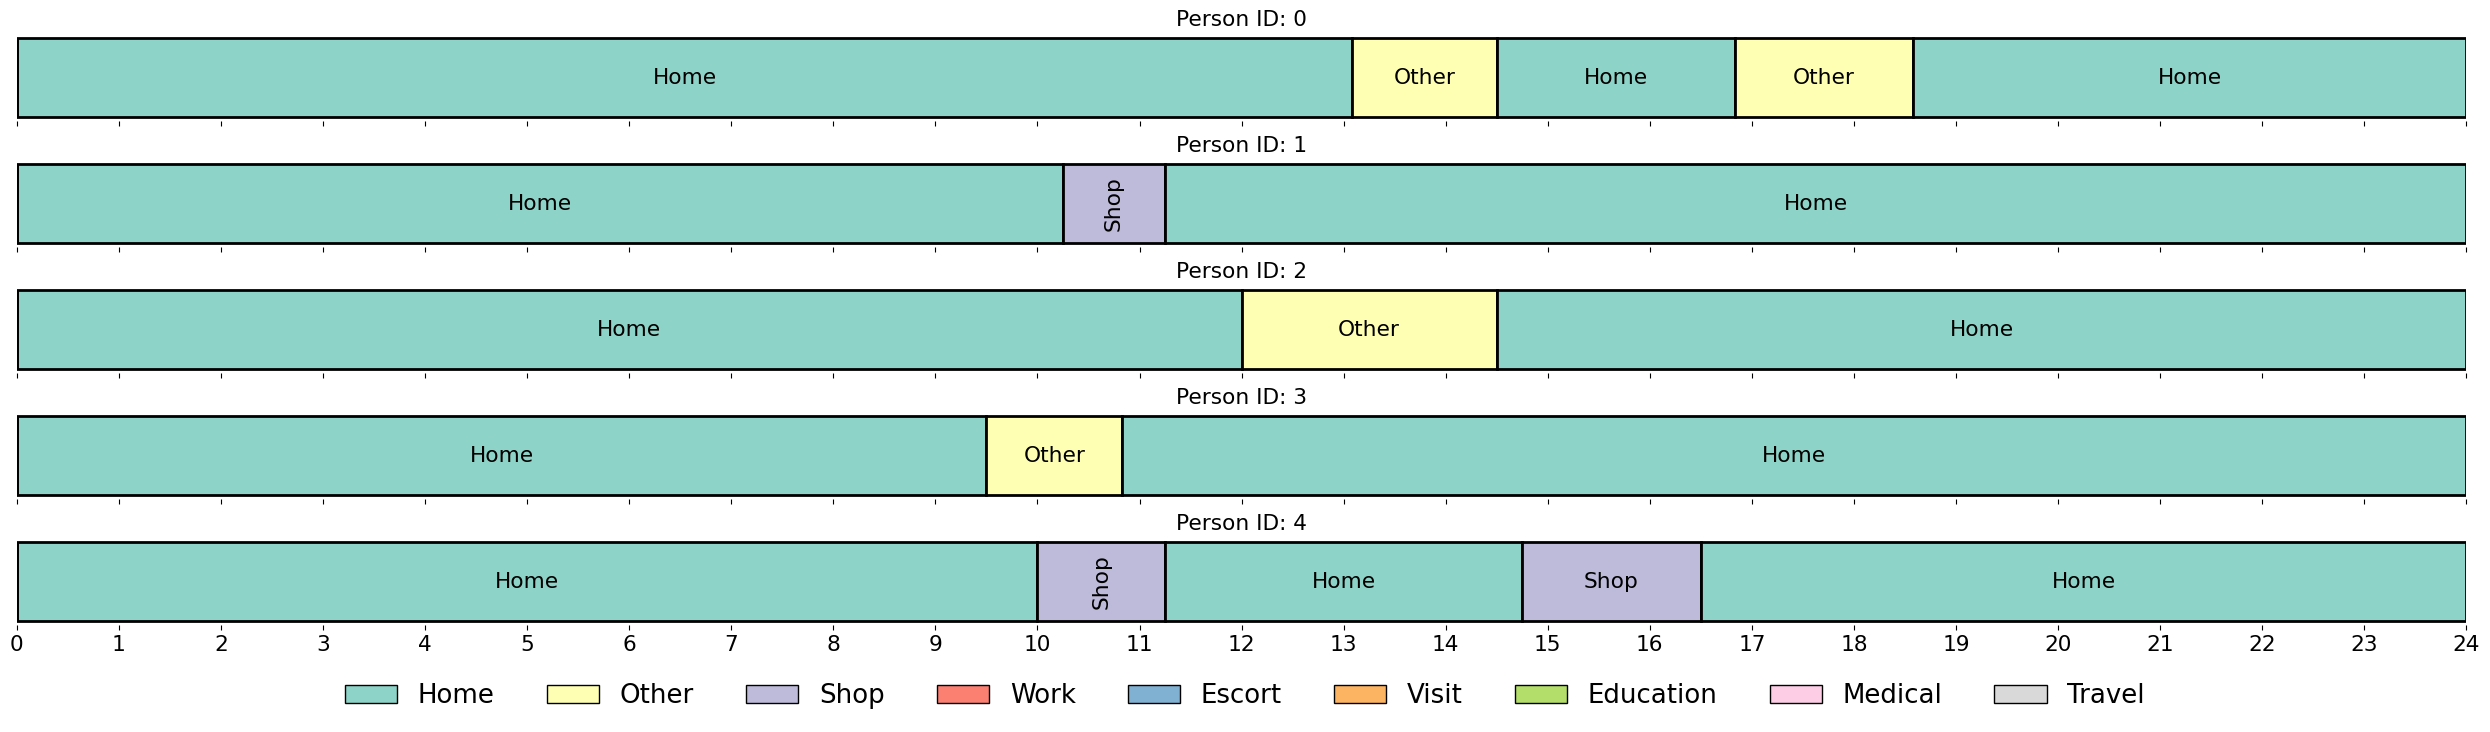

In [8]:
plot_schedules(target_schedules)

C:\Users\fred\AppData\Local\Temp\ipykernel_16152\1738895634.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  schedules.groupby(schedules["pid"]).apply(padder).reset_index(drop=True)
C:\Users\fred\AppData\Local\Temp\ipykernel_16152\1738895634.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return schedules.groupby(schedules.pid).apply(stretcher)
C:\Users\fred\AppData\Local\Temp\ipykernel_16152\17388

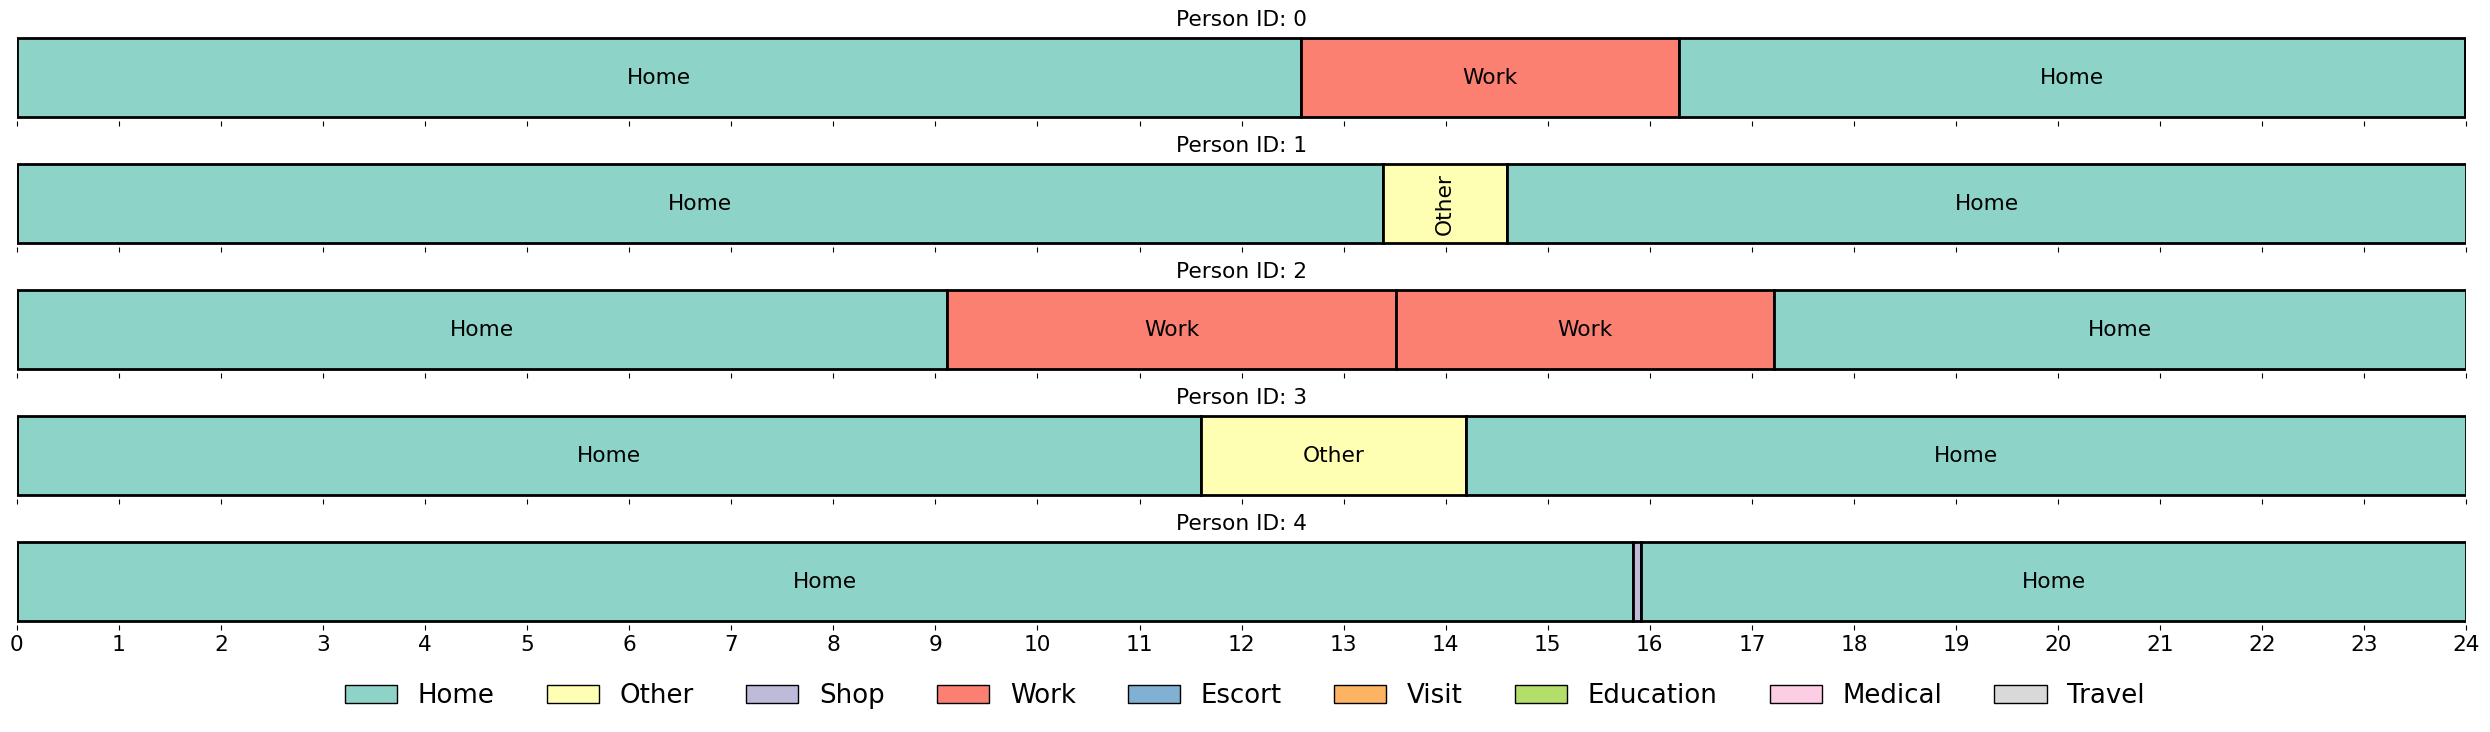

In [9]:
p = batch_paths["CVAE"]
examples = pd.read_csv(latest(p)[1] / "synthetic_schedules.csv")
plot_schedules(examples)

In [10]:
def split_on(schedules, attributes, by="work_status"):
    splits = attributes.groupby(by)
    return {
        k.title(): schedules.loc[schedules.pid.isin(list(v.pid))]
        for k, v in splits
    }

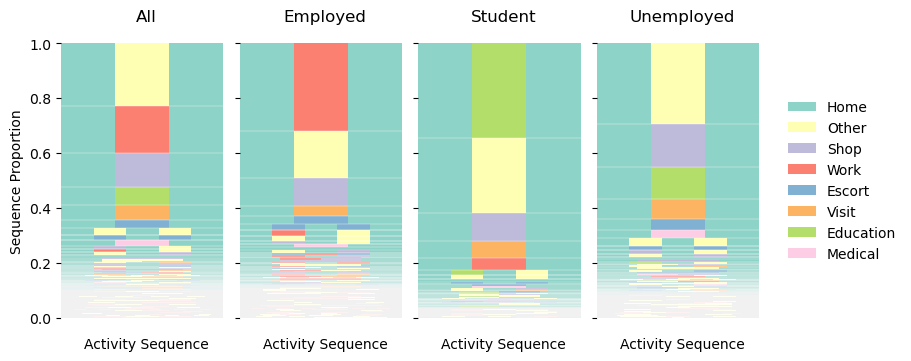

In [11]:
splits = split_on(target_schedules, target_attributes)
fig = transitions.sequence_prob_plot(
    target_schedules, splits, observed_title="All", cmap=cmap, figsize=(9, 3.5)
)

CVAE
Add
Feed
After
All
Nudge
DoubleNudge
NudgeAdv


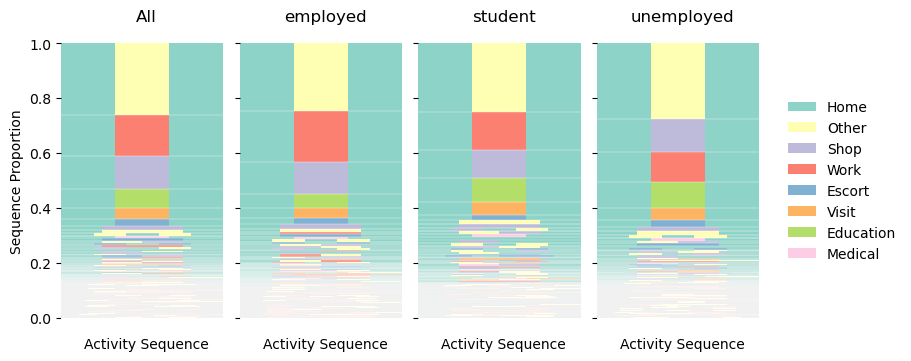

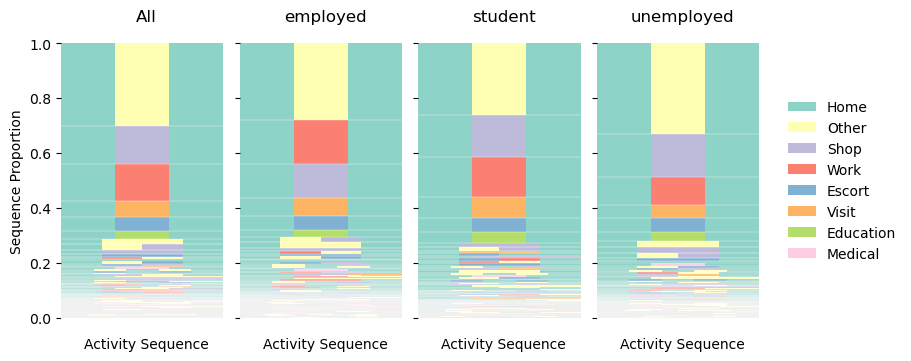

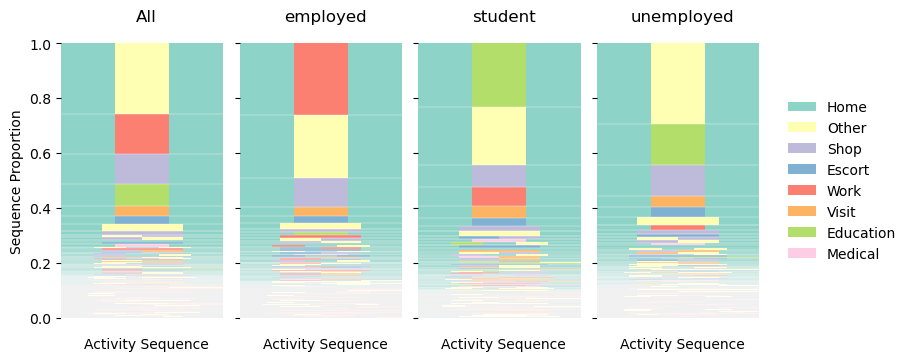

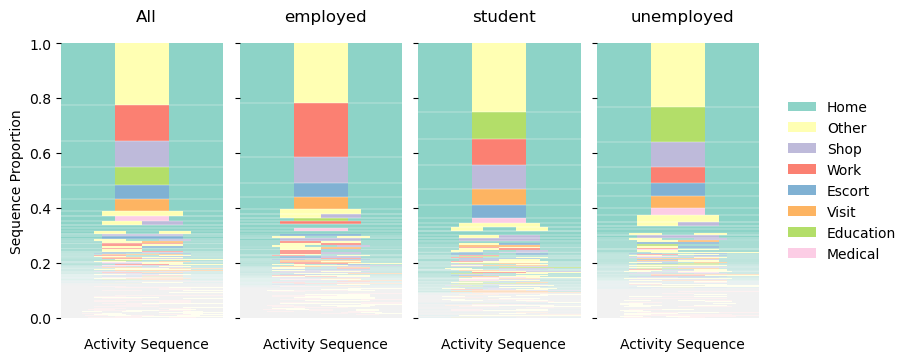

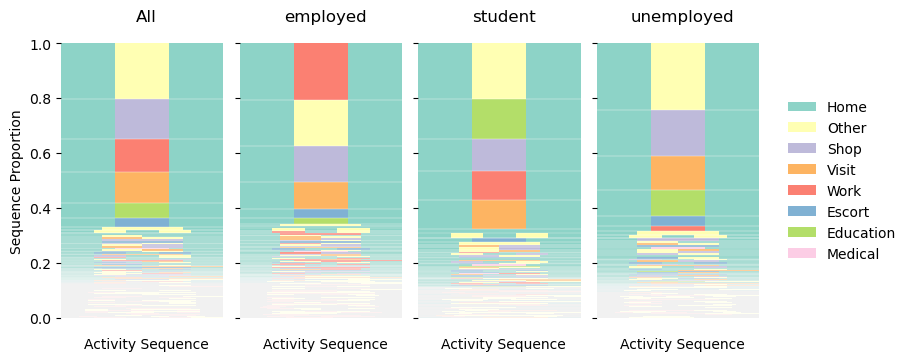

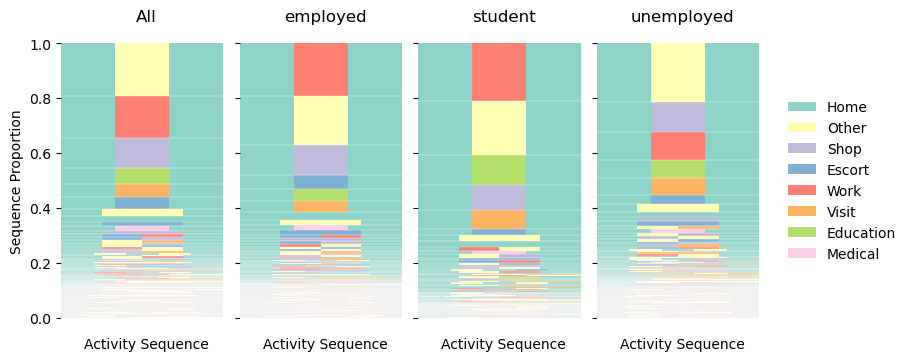

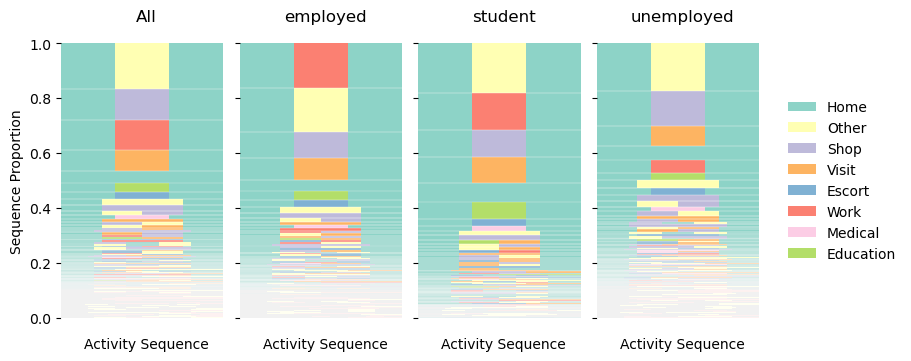

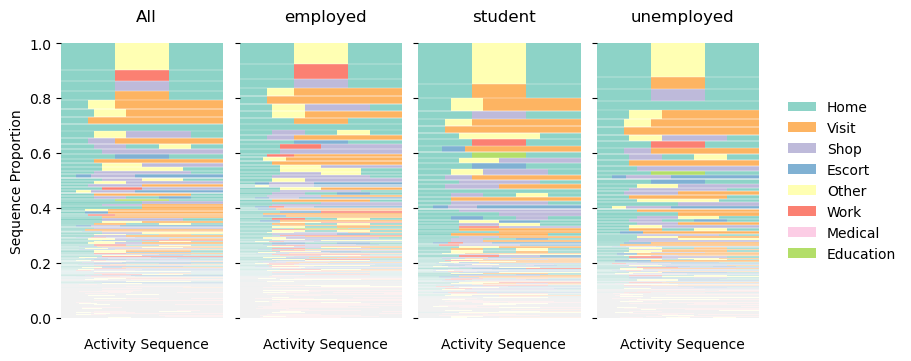

In [18]:
for k, scheds in schedules.items():
    print(k)


    splits = split_on(scheds, attributes[k])


    fig = transitions.sequence_prob_plot(
        scheds, splits, observed_title="All", cmap=cmap, figsize=(9, 3.5)
    )

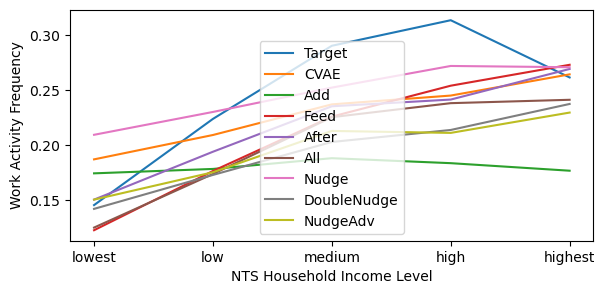

In [13]:
def split_on(schedules, attributes, by="work_status"):
    splits = attributes.groupby(by)
    return {
        k: schedules.loc[schedules.pid.isin(list(v.pid))] for k, v in splits
    }


def count_trips(schedules):
    n = schedules.pid.nunique()
    return (len(schedules) - n) / n


def count_acts(schedules, act="work"):
    n = schedules.pid.nunique()
    return len(split.loc[split.act == act]) / n


splits = split_on(target_schedules, target_attributes, by="income")
data = {"Target": {}}
for i, split in splits.items():
    data["Target"][i] = count_acts(split)


for n, scheds in schedules.items():
    data[n] = {}
    atts = attributes[n]
    splits = split_on(scheds, atts, by="income")
    for i, split in splits.items():
        data[n][i] = count_acts(split)

df = pd.DataFrame(data)
fig, ax = plt.subplots(figsize=(9 * 0.75, 3))
df.plot(ax=ax)
ax.set_ylabel("Work Activity Frequency")
ax.set_xlabel("NTS Household Income Level")
ax.set_xticks([1, 2, 3, 4, 5], ["lowest", "low", "medium", "high", "highest"])

Text(0.5, 0, 'Age Group')

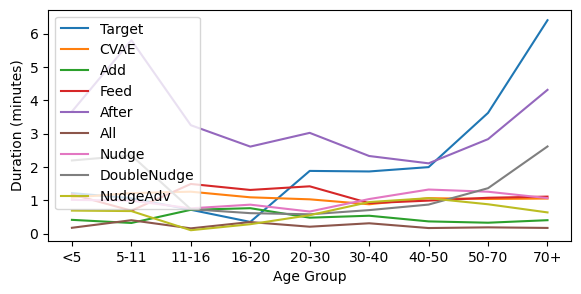

In [14]:
def norm_first(df):
    start = df.first().end / df.last().end
    return start


def first_act_start(schedules):
    return schedules.groupby("pid").norm_first().mean()


def meds(schedules):
    n = schedules.pid.nunique()
    return schedules[schedules.act == "medical"].duration.sum() / n


def time_at_home(schedules):
    return schedules.loc[schedules.act == "home"].duration.mean()


splits = split_on(target_schedules, target_attributes, by="age_group")
data = {"Target": {}}
for i, split in splits.items():
    data["Target"][i] = meds(split)

for n, scheds in schedules.items():
    data[n] = {}
    atts = attributes[n]
    splits = split_on(scheds, atts, by="age_group")
    for i, split in splits.items():
        data[n][i] = meds(split)

order = [
    "<5",
    "5-11",
    "11-16",
    "16-20",
    "20-30",
    "30-40",
    "40-50",
    "50-70",
    "70+",
]

df = pd.DataFrame(data)
fig, ax = plt.subplots(figsize=(9 * 0.75, 3))
df.loc[order].plot(ax=ax)
ax.set_ylabel("Duration (minutes)")
ax.set_xlabel("Age Group")

In [15]:
target_attributes.head()

,Unnamed: 0,pid,age,gender,ethnicity,education,license,car_access,work_status,area,income,hh_size,hh_composition,hh_children,hh_cars,hh_bikes,hh_motorcycles,age_group
0,0,0,50,M,white,N,yes,yes,unemployed,urban,1,1,1adult,0,1.0,0,0.0,50-70
1,1,1,50,M,white,N,yes,yes,unemployed,urban,1,1,1adult,0,1.0,0,0.0,50-70
2,2,2,50,M,white,N,yes,yes,unemployed,urban,1,1,1adult,0,1.0,0,0.0,50-70
3,3,3,50,M,white,N,yes,yes,unemployed,urban,1,1,1adult,0,1.0,0,0.0,50-70
4,4,4,50,M,white,N,yes,yes,unemployed,urban,1,1,1adult,0,1.0,0,0.0,50-70


In [16]:
def build_distance_tables(batch_paths, suffix=""):
    distances_combined = pd.DataFrame()

    for name, path in batch_paths.items():
        distances = pd.read_csv(
            path / f"domain_distances{suffix}.csv"
        ).set_index("domain")

        columns = list(
            set(distances.columns) - set(["domain", "observed", "mean", "std"])
        )
        distances_combined[(name, "EMD")] = distances[columns].mean(axis=1)
        distances_combined[(name, "var")] = distances[columns].var(axis=1)

    distances_combined.columns = pd.MultiIndex.from_tuples(
        distances_combined.columns
    )

    # distances_combined = distances_combined.set_index(
    #     pd.MultiIndex.from_tuples(distances_combined.index)
    # )

    return distances_combined


df = build_distance_tables(batch_paths, suffix="")
print(df[::-1].to_latex(float_format="{:.3f}".format))
df

FileNotFoundError: [Errno 2] No such file or directory: '..\\logs\\cvaes\\CVAE\\domain_distances.csv'

In [19]:
df = build_distance_tables(batch_paths, suffix="_subs")
print(df[::-1].to_latex(float_format="{:.3f}".format))
df

\begin{tabular}{lrrrrrr}
\toprule
 & EMD & var & EMD & var & EMD & var \\
domain &  &  &  &  &  &  \\
\midrule
aggregate & 0.038 & 0.000 & 0.022 & 0.000 & 0.023 & 0.000 \\
count & 0.000 & 0.000 & 537.273 & 0.000 & 1725.673 & 1283.209 \\
creativity & 0.571 & 0.000 & 0.001 & 0.000 & 0.001 & 0.000 \\
participations & 0.594 & 0.000 & 0.084 & 0.000 & 0.070 & 0.000 \\
sample quality & 0.000 & 0.000 & 0.053 & 0.000 & 0.050 & 0.000 \\
timing & 0.261 & 0.000 & 0.075 & 0.000 & 0.076 & 0.000 \\
transitions & 0.049 & 0.000 & 0.016 & 0.000 & 0.011 & 0.000 \\
\bottomrule
\end{tabular}



Disc. RNN           Cont. RNN VAE               Cont. RNN JVAE  \
                     EMD       var           EMD           var            EMD   
domain                                                                          
aggregate       0.038111  0.000002      0.022436  2.395341e-06       0.022893   
count           0.000000  0.000000    537.272727  0.000000e+00    1725.672727   
creativity      0.571127  0.000029      0.000583  6.789731e-08       0.000609   
participations  0.593569  0.000182      0.084261  4.884318e-05       0.070435   
sample quality  0.000000  0.000000      0.053144  6.241693e-05       0.049504   
timing          0.260965  0.000027      0.074874  2.211997e-06       0.075864   
transitions     0.049030  0.000006      0.016378  1.239787e-06       0.010777   

                              
                         var  
domain                        
aggregate       5.343327e-06  
count           1.283209e+03  
creativity      3.870372e-08  
participations  1.015447e-04  
sample quality  1.171351e-05  
timing          8.075473e-06  
transitions     2.390222e-07

In [41]:
def build_feature_description_tables(batch_paths):
    descriptions_combined = pd.DataFrame()

    for name, path in batch_paths.items():

        descriptions = pd.read_csv(path / "feature_descriptions.csv").set_index(
            ["domain", "feature"]
        )
        distances = pd.read_csv(path / "feature_distances.csv").set_index(
            ["domain", "feature"]
        )
        print(distances.columns)

        columns = set(descriptions.columns)
        columns = list(
            columns - set(["observed", "description", "mean", "std"])
        )
        assert len(columns) == 5

        descriptions_combined[(name, "mean")] = descriptions[columns].mean(
            axis=1
        )
        # descriptions_combined[(name, "var")] = descriptions[columns].var(axis=1)
        descriptions_combined[(name, "EMD")] = distances[columns].mean(axis=1)

    descriptions_combined.columns = pd.MultiIndex.from_tuples(
        descriptions_combined.columns
    )

    descriptions_combined[("Observed", "")] = descriptions["observed"]
    descriptions_combined[("Description", "")] = descriptions["description"]

    order = list(descriptions_combined.columns)
    order.pop(order.index(("Observed", "")))
    order = [("Observed", "")] + order

    index = [
        "creativity",
        "sample quality",
        "aggregate",
        "participations",
        "transitions",
        "timing",
    ]

    return descriptions_combined.loc[index, order]


table = build_feature_description_tables(batch_paths)
table

Index(['observed', 'DiscLSTM1', 'DiscLSTM2', 'DiscLSTM3', 'DiscLSTM4',
       'DiscLSTM5', 'distance'],
      dtype='object')
Index(['observed', 'paper_c_rnn_vae_nrun0', 'paper_c_rnn_vae_nrun1',
       'paper_c_rnn_vae_nrun2', 'paper_c_rnn_vae_nrun3',
       'paper_c_rnn_vae_nrun4', 'distance'],
      dtype='object')
Index(['observed', 'A', 'B', 'C', 'D', 'E', 'distance'], dtype='object')


Observed Disc. RNN            \
                                                      mean       EMD   
domain         feature                                                 
creativity     diversity                0.549724  0.002911       NaN   
               novelty                  1.000000  0.759261       NaN   
sample quality duration                 1.000000  1.000000  0.000000   
               home based               1.000000  1.000000  0.000000   
aggregate      agg. frequency           0.688881  0.863521  0.032199   
participations lengths                  3.680427  1.724881  1.955546   
               pair participation rate  0.038617  0.036334  0.040064   
               participation rate       0.085591  0.266117  0.066955   
transitions    2-gram                   0.041891  0.334120  0.062181   
               3-gram                   0.005097  0.267847  0.007315   
timing         durations                0.271708  0.580145  0.186918   
               end times                0.683808  0.803907  0.257816   
               start times              0.412100  0.223761  0.127847   
               start-durations          0.689380  0.810646  0.446209   

                                       Cont. RNN VAE           Cont. RNN JVAE  \
                                                mean       EMD           mean   
domain         feature                                                          
creativity     diversity                    0.994660       NaN       0.995138   
               novelty                      0.999946       NaN       0.999925   
sample quality duration                     0.973597  0.087803       0.974614   
               home based                   0.981121  0.018879       0.976457   
aggregate      agg. frequency               0.760902  0.017256       0.767740   
participations lengths                      3.524109  0.186844       3.517000   
               pair participation rate      0.038162  0.005680       0.037777   
               participation rate           0.080965  0.009119       0.083367   
transitions    2-gram                       0.042009  0.010643       0.043626   
               3-gram                       0.004936  0.002583       0.005214   
timing         durations                    0.276320  0.050464       0.277173   
               end times                    0.706178  0.070662       0.709399   
               start times                  0.429858  0.045810       0.432227   
               start-durations              0.708213  0.103464       0.711479   

                                                    Description  
                                             EMD                 
domain         feature                                           
creativity     diversity                     NaN   prob. unique  
               novelty                       NaN    prob. novel  
sample quality duration                 0.077332       duration  
               home based               0.023543          prob.  
aggregate      agg. frequency           0.020107  average freq.  
participations lengths                  0.202466        length.  
               pair participation rate  0.006880       av rate.  
               participation rate       0.009528       av. rate  
transitions    2-gram                   0.011219       av. rate  
               3-gram                   0.002826       av. rate  
timing         durations                0.055201        average  
               end times                0.073745        average  
               start times              0.049316        average  
               start-durations          0.109917        average

In [42]:
for n in ["aggregate", "participations", "transitions", "timing"]:
    print(n)
    print(table.loc[n].to_latex(float_format="{:.3f}".format))
    print()

aggregate
\begin{tabular}{lrrrrrrrl}
\toprule
 & Observed & \multicolumn{2}{r}{Disc. RNN} & \multicolumn{2}{r}{Cont. RNN VAE} & \multicolumn{2}{r}{Cont. RNN JVAE} & Description \\
 &  & mean & EMD & mean & EMD & mean & EMD &  \\
feature &  &  &  &  &  &  &  &  \\
\midrule
agg. frequency & 0.689 & 0.864 & 0.032 & 0.761 & 0.017 & 0.768 & 0.020 & average freq. \\
\bottomrule
\end{tabular}


participations
\begin{tabular}{lrrrrrrrl}
\toprule
 & Observed & \multicolumn{2}{r}{Disc. RNN} & \multicolumn{2}{r}{Cont. RNN VAE} & \multicolumn{2}{r}{Cont. RNN JVAE} & Description \\
 &  & mean & EMD & mean & EMD & mean & EMD &  \\
feature &  &  &  &  &  &  &  &  \\
\midrule
lengths & 3.680 & 1.725 & 1.956 & 3.524 & 0.187 & 3.517 & 0.202 & length. \\
pair participation rate & 0.039 & 0.036 & 0.040 & 0.038 & 0.006 & 0.038 & 0.007 & av rate. \\
participation rate & 0.086 & 0.266 & 0.067 & 0.081 & 0.009 & 0.083 & 0.010 & av. rate \\
\bottomrule
\end{tabular}


transitions
\begin{tabular}{lrrrrrrrl}
\top

In [43]:
def build_creativity_table(batch_paths):
    descriptions_combined = pd.DataFrame()
    distances_combined = pd.DataFrame()

    for name, path in batch_paths.items():

        descriptions = (
            pd.read_csv(path / "descriptions.csv")
            .set_index(["domain", "feature", "segment"])
            .loc["creativity"]
        )
        distances = (
            pd.read_csv(path / "distances.csv")
            .set_index(["domain", "feature", "segment"])
            .loc["creativity"]
        )

        columns = set(descriptions.columns)
        weights = set([c for c in columns if "weight" in c])
        columns = list(
            columns
            - set(["observed", "description", "mean", "std", "feature count"])
            - weights
        )

        descriptions_combined[name, "desc."] = descriptions[columns].mean(
            axis=1
        )

        distances_combined[name, "dist."] = distances[columns].mean(axis=1)

    descriptions_combined["Observed", ""] = descriptions["observed"]
    descriptions_combined["Description", ""] = descriptions["description"]

    print(descriptions_combined.columns)

    descriptions_combined.columns = pd.MultiIndex.from_tuples(
        descriptions_combined.columns
    )

    distances_combined["Observed", ""] = distances["observed"]
    distances_combined["Description", ""] = distances["distance"]

    distances_combined.columns = pd.MultiIndex.from_tuples(
        distances_combined.columns
    )

    order = list(descriptions_combined.columns)
    order.pop(order.index(("Observed", "")))
    order.pop(order.index(("Description", "")))
    order = [("Observed", "")] + order + [("Description", "")]
    descriptions_combined = descriptions_combined.loc[:, order]

    order = list(distances_combined.columns)
    order.pop(order.index(("Observed", "")))
    order.pop(order.index(("Description", "")))
    order = [("Observed", "")] + order + [("Description", "")]
    distances_combined = distances_combined.loc[:, order]

    return pd.concat((descriptions_combined, distances_combined), axis=0)


table = build_creativity_table(batch_paths)
table

Index([     ('Disc. RNN', 'desc.'),  ('Cont. RNN VAE', 'desc.'),
       ('Cont. RNN JVAE', 'desc.'),            ('Observed', ''),
               ('Description', '')],
      dtype='object')


,,Observed,Disc. RNN,Cont. RNN VAE,Cont. RNN JVAE,Description,Disc. RNN,Cont. RNN VAE,Cont. RNN JVAE
,,,desc.,desc.,desc.,,dist.,dist.,dist.
feature,segment,,,,,,,,
diversity,all,0.549724,0.002911,0.994660,0.995138,prob. unique,NaN,NaN,NaN
novelty,all,1.000000,0.759261,0.999946,0.999925,prob. novel,NaN,NaN,NaN
homogeneity,all,0.450276,NaN,NaN,NaN,prob. not unique,0.997089,0.005340,0.004862
conservatism,all,0.000000,NaN,NaN,NaN,prob. conservative,0.240739,0.000054,0.000075


In [44]:
def build_all_description_tables(batch_paths):
    descriptions_combined = pd.DataFrame()

    for name, path in batch_paths.items():

        descriptions = pd.read_csv(path / "descriptions.csv").set_index(
            ["domain", "feature", "segment"]
        )
        distances = pd.read_csv(path / "distances.csv").set_index(
            ["domain", "feature", "segment"]
        )

        columns = set(descriptions.columns)
        weights = set([c for c in columns if "weight" in c])
        columns = list(
            columns
            - set(["observed", "description", "mean", "std", "feature count"])
            - weights
        )

        descriptions_combined[name, "mean"] = descriptions[columns].mean(axis=1)
        # descriptions_combined[name, "var"] = descriptions[columns].var(axis=1)
        descriptions_combined[name, "EMD"] = distances[columns].mean(axis=1)

    descriptions_combined["weight", ""] = distances["observed__weight"]
    descriptions_combined["Observed", ""] = descriptions["observed"]
    descriptions_combined["Description", ""] = descriptions["description"]

    descriptions_combined.columns = pd.MultiIndex.from_tuples(
        descriptions_combined.columns
    )

    descriptions_combined = descriptions_combined.groupby(
        ["domain", "feature"], group_keys=False
    ).apply(
        lambda x: x.sort_values(
            [("weight", ""), ("Observed", "")], ascending=False
        ).head(20)
    )
    descriptions_combined = descriptions_combined.drop(("weight", ""), axis=1)

    order = list(descriptions_combined.columns)
    order.pop(order.index(("Observed", "")))
    order = [("Observed", "")] + order

    index = [
        "aggregate",
        "participations",
        "transitions",
        "timing",
        "sample quality",
        "creativity",
    ]

    return descriptions_combined.loc[index, order]


table = build_all_description_tables(batch_paths)

In [45]:
print(table.loc["sample quality"].to_latex(float_format="{:.3f}".format))
table.loc["sample quality"]

\begin{tabular}{llrrrrrrrl}
\toprule
 &  & Observed & \multicolumn{2}{r}{Disc. RNN} & \multicolumn{2}{r}{Cont. RNN VAE} & \multicolumn{2}{r}{Cont. RNN JVAE} & Description \\
 &  &  & mean & EMD & mean & EMD & mean & EMD &  \\
feature & segment &  &  &  &  &  &  &  &  \\
\midrule
duration & total duration & 1.000 & 1.000 & 0.000 & 0.974 & 0.088 & 0.975 & 0.077 & duration \\
\cline{1-10}
\multirow[t]{2}{*}{home based} & first act home & 1.000 & 1.000 & 0.000 & 1.000 & 0.000 & 1.000 & 0.000 & prob. \\
 & last act home & 1.000 & 1.000 & 0.000 & 0.962 & 0.038 & 0.953 & 0.047 & prob. \\
\cline{1-10}
\bottomrule
\end{tabular}



Observed Disc. RNN      Cont. RNN VAE            \
                                        mean  EMD          mean       EMD   
feature    segment                                                          
duration   total duration      1.0       1.0  0.0      0.973597  0.087803   
home based first act home      1.0       1.0  0.0      1.000000  0.000000   
           last act home       1.0       1.0  0.0      0.962242  0.037758   

                          Cont. RNN JVAE           Description  
                                    mean       EMD              
feature    segment                                              
duration   total duration       0.974614  0.077332    duration  
home based first act home       0.999995  0.000005       prob.  
           last act home        0.952919  0.047081       prob.

In [46]:
table.loc["creativity"]

Observed Disc. RNN     Cont. RNN VAE     Cont. RNN JVAE  \
                                 mean EMD          mean EMD           mean   
feature   segment                                                            
diversity all      0.549724  0.002911 NaN      0.994660 NaN       0.995138   
novelty   all      1.000000  0.759261 NaN      0.999946 NaN       0.999925   

                        Description  
                  EMD                
feature   segment                    
diversity all     NaN  prob. unique  
novelty   all     NaN   prob. novel

In [47]:
p = table.loc["participations"]
for name in ["lengths", "participation rate", "pair participation rate"]:
    print(name)
    print(p.loc[name].to_latex(float_format="{:.3f}".format))
    print()

table.loc["participations"]

lengths
\begin{tabular}{lrrrrrrrl}
\toprule
 & Observed & \multicolumn{2}{r}{Disc. RNN} & \multicolumn{2}{r}{Cont. RNN VAE} & \multicolumn{2}{r}{Cont. RNN JVAE} & Description \\
 &  & mean & EMD & mean & EMD & mean & EMD &  \\
segment &  &  &  &  &  &  &  &  \\
\midrule
sequence lengths & 3.680 & 1.725 & 1.956 & 3.524 & 0.187 & 3.517 & 0.202 & length. \\
\bottomrule
\end{tabular}


participation rate
\begin{tabular}{lrrrrrrrl}
\toprule
 & Observed & \multicolumn{2}{r}{Disc. RNN} & \multicolumn{2}{r}{Cont. RNN VAE} & \multicolumn{2}{r}{Cont. RNN JVAE} & Description \\
 &  & mean & EMD & mean & EMD & mean & EMD &  \\
segment &  &  &  &  &  &  &  &  \\
\midrule
home0 & 1.000 & 1.000 & 0.000 & 1.000 & 0.000 & 1.000 & 0.000 & av. rate \\
home1 & 1.000 & 0.362 & 0.638 & 0.968 & 0.032 & 0.959 & 0.041 & av. rate \\
other0 & 0.394 & 0.014 & 0.380 & 0.375 & 0.027 & 0.401 & 0.018 & av. rate \\
work0 & 0.237 & 0.224 & 0.019 & 0.247 & 0.019 & 0.246 & 0.010 & av. rate \\
shop0 & 0.233 & 0.000 & 0.23

Observed Disc. RNN            \
                                                        mean       EMD   
feature                 segment                                          
lengths                 sequence lengths  3.680427  1.724881  1.955546   
pair participation rate home+home         1.039565  0.361545  0.678020   
                        escort+escort     0.069613  0.000000  0.069613   
                        home+escort       0.067201  0.000000  0.067201   
                        other+other       0.056318  0.000021  0.056297   
                        home+other        0.055246  0.000021  0.055224   
                        shop+shop         0.023401  0.000000  0.023401   
                        home+shop         0.023160  0.000000  0.023160   
                        work+work         0.013027  0.000472  0.012556   
                        home+work         0.011982  0.000472  0.011510   
                        visit+visit       0.009864  0.000000  0.009864   
                        home+visit        0.009784  0.000000  0.009784   
                        escort+other      0.002493  0.000000  0.002493   
                        shop+escort       0.001447  0.000000  0.001447   
                        shop+other        0.001153  0.000000  0.001153   
                        home+medical      0.001019  0.000000  0.001019   
                        medical+medical   0.001019  0.000000  0.001019   
                        work+escort       0.000911  0.000000  0.000911   
                        escort+visit      0.000697  0.000000  0.000697   
                        other+visit       0.000563  0.000000  0.000563   
                        shop+visit        0.000536  0.000000  0.000536   
participation rate      home0             1.000000  1.000000  0.000000   
                        home1             0.999786  0.361545  0.638240   
                        other0            0.393690  0.014041  0.379649   
                        work0             0.237174  0.224125  0.019118   
                        shop0             0.232510  0.000000  0.232510   
                        home2             0.205624  0.000895  0.204728   
                        escort0           0.139897  0.000000  0.139897   
                        visit0            0.109419  0.000000  0.109419   
                        education0        0.074814  0.123380  0.048566   
                        escort1           0.064762  0.000000  0.064762   
                        other1            0.054361  0.000021  0.054340   
                        home3             0.038332  0.000000  0.038332   
                        medical0          0.037233  0.000000  0.037233   
                        shop1             0.022999  0.000000  0.022999   
                        work1             0.011768  0.000472  0.011296   
                        escort2           0.011419  0.000000  0.011419   
                        other2            0.010293  0.000000  0.010293   
                        visit1            0.009757  0.000000  0.009757   
                        home4             0.005763  0.000000  0.005763   
                        escort3           0.004316  0.000000  0.004316   

                                         Cont. RNN VAE            \
                                                  mean       EMD   
feature                 segment                                    
lengths                 sequence lengths      3.524109  0.186844   
pair participation rate home+home             0.974154  0.065410   
                        escort+escort         0.054570  0.016030   
                        home+escort           0.044851  0.022350   
                        other+other           0.070503  0.014904   
                        home+other            0.062917  0.009870   
                        shop+shop             0.034890  0.011489   
                        home+shop             0.030027  0.008015   
                        work+work    

In [48]:
t = table.loc["transitions"]
for name in ["2-gram", "3-gram"]:
    print(name)
    print(t.loc[name].to_latex(float_format="{:.3f}".format))
    print()

table.loc["transitions"]

2-gram
\begin{tabular}{lrrrrrrrl}
\toprule
 & Observed & \multicolumn{2}{r}{Disc. RNN} & \multicolumn{2}{r}{Cont. RNN VAE} & \multicolumn{2}{r}{Cont. RNN JVAE} & Description \\
 &  & mean & EMD & mean & EMD & mean & EMD &  \\
segment &  &  &  &  &  &  &  &  \\
\midrule
other>home & 0.414 & 0.039 & 0.375 & 0.351 & 0.063 & 0.358 & 0.060 & av. rate \\
home>other & 0.414 & 0.039 & 0.375 & 0.353 & 0.061 & 0.376 & 0.044 & av. rate \\
home>work & 0.229 & 0.620 & 0.400 & 0.234 & 0.021 & 0.231 & 0.010 & av. rate \\
work>home & 0.225 & 0.620 & 0.404 & 0.212 & 0.021 & 0.208 & 0.017 & av. rate \\
shop>home & 0.224 & 0.000 & 0.224 & 0.211 & 0.020 & 0.184 & 0.040 & av. rate \\
home>shop & 0.213 & 0.000 & 0.213 & 0.200 & 0.020 & 0.186 & 0.028 & av. rate \\
home>escort & 0.178 & 0.000 & 0.178 & 0.118 & 0.059 & 0.106 & 0.071 & av. rate \\
escort>home & 0.169 & 0.000 & 0.169 & 0.098 & 0.071 & 0.100 & 0.069 & av. rate \\
visit>home & 0.103 & 0.000 & 0.103 & 0.089 & 0.023 & 0.094 & 0.012 & av. rate \\
hom

Observed Disc. RNN           Cont. RNN VAE  \
                                           mean       EMD          mean   
feature segment                                                           
2-gram  other>home           0.414365  0.038918  0.375448      0.351187   
        home>other           0.414258  0.038918  0.375341      0.352914   
        home>work            0.229288  0.619744  0.399925      0.233894   
        work>home            0.224838  0.619744  0.404419      0.211992   
        shop>home            0.224221  0.000000  0.224221      0.210796   
        home>shop            0.213363  0.000000  0.213363      0.199505   
        home>escort          0.177543  0.000000  0.177543      0.118164   
        escort>home          0.168829  0.000000  0.168829      0.097956   
        visit>home           0.102552  0.000000  0.102552      0.088682   
        home>visit           0.093973  0.000000  0.093973      0.077374   
        home>education       0.072738  0.343700  0.271025      0.067685   
        education>home       0.070084  0.343700  0.273680      0.055369   
        home>medical         0.034854  0.000000  0.034854      0.025741   
        medical>home         0.031128  0.000000  0.031128      0.021532   
        other>other          0.019170  0.000000  0.019170      0.056720   
        escort>escort        0.019009  0.000000  0.019009      0.044817   
        home>home            0.015443  0.000000  0.015443      0.021135   
        shop>shop            0.014987  0.000000  0.014987      0.037257   
        escort>work          0.010805  0.000000  0.010805      0.011195   
        other>shop           0.010322  0.000000  0.010322      0.018294   
3-gram  home>other>home      0.388414  0.038918  0.349496      0.285956   
        home>work>home       0.214050  0.619744  0.414065      0.196506   
        home>shop>home       0.192041  0.000000  0.192041      0.160546   
        home>escort>home     0.136573  0.000000  0.136573      0.058057   
        home>visit>home      0.081835  0.000000  0.081835      0.058597   
        home>education>home  0.069383  0.343700  0.274382      0.053867   
        other>home>other     0.038116  0.000061  0.038055      0.020802   
        escort>home>escort   0.037466  0.000000  0.037466      0.011669   
        home>medical>home    0.029074  0.000000  0.029074      0.014081   
        shop>home>other      0.019870  0.000000  0.019870      0.005935   
        other>home>shop      0.016351  0.000000  0.016351      0.007594   
        work>home>other      0.014348  0.000000  0.014348      0.007148   
        home>escort>escort   0.013508  0.000000  0.013508      0.022895   
        other>home>escort    0.013508  0.000000  0.013508      0.003425   
        escort>escort>home   0.012994  0.000000  0.012994      0.023098   
        other>other>home     0.012994  0.000000  0.012994      0.037486   
        home>other>other     0.012561  0.000000  0.012561      0.040164   
        escort>home>other    0.012371  0.000000  0.012371      0.002688   
        shop>shop>home       0.011911  0.000000  0.011911      0.020807   
        home>shop>shop       0.011424  0.000000  0.011424      0.020392   

                                      Cont. RNN JVAE           Description  
                                  EMD           mean       EMD              
feature segment                                                             
2-gram  other>home           0.063179       0.357959  0.059718    av. rate  
        home>other           0.061344       0.375645  0.044487    av. rate  
        home>work            0.021349       0.230818  0.010465    av. rate  
        work>home            0.021111       0.207983  0.016855    av. rate  
        shop>home            0.020427       0.184060  0.040161    av. rate  
        home>shop            0.019603       0.185545  0.027828    av. rate  
        home>escort          0.059379       0.106394  0.071149    av. rate  
        escort>home          0.07

In [49]:
t = table.loc["timing"]
for name in ["durations", "start times", "end times", "start-durations"]:
    print(name)
    print(t.loc[name].to_latex(float_format="{:.3f}".format))
    print()

table.loc["timing"]

durations
\begin{tabular}{lrrrrrrrl}
\toprule
 & Observed & \multicolumn{2}{r}{Disc. RNN} & \multicolumn{2}{r}{Cont. RNN VAE} & \multicolumn{2}{r}{Cont. RNN JVAE} & Description \\
 &  & mean & EMD & mean & EMD & mean & EMD &  \\
segment &  &  &  &  &  &  &  &  \\
\midrule
home0 & 0.458 & 0.795 & 0.338 & 0.530 & 0.089 & 0.538 & 0.097 & average \\
home1 & 0.307 & 0.366 & 0.106 & 0.298 & 0.032 & 0.298 & 0.037 & average \\
other0 & 0.079 & 0.073 & 0.058 & 0.029 & 0.051 & 0.024 & 0.055 & average \\
work0 & 0.339 & 0.190 & 0.151 & 0.298 & 0.044 & 0.298 & 0.043 & average \\
shop0 & 0.051 & 0.000 & 0.051 & 0.022 & 0.030 & 0.016 & 0.035 & average \\
home2 & 0.244 & 0.298 & 0.168 & 0.270 & 0.038 & 0.272 & 0.043 & average \\
escort0 & 0.030 & 0.000 & 0.030 & 0.023 & 0.007 & 0.030 & 0.007 & average \\
visit0 & 0.136 & 0.000 & 0.136 & 0.082 & 0.056 & 0.073 & 0.064 & average \\
education0 & 0.293 & 0.231 & 0.062 & 0.230 & 0.064 & 0.243 & 0.052 & average \\
escort1 & 0.020 & 0.000 & 0.020 & 0.042 & 0

Observed Disc. RNN           Cont. RNN VAE  \
                                         mean       EMD          mean   
feature         segment                                                 
durations       home0      0.457594  0.795095  0.337501      0.529569   
                home1      0.306878  0.366400  0.105522      0.297552   
                other0     0.079479  0.073494  0.057550      0.028706   
                work0      0.338817  0.189890  0.150727      0.297814   
                shop0      0.051317  0.000000  0.051317      0.021574   
...                             ...       ...       ...           ...   
start-durations work       0.708265  0.640377  0.234669      0.732311   
                escort     0.568512  0.000000  0.568512      0.602529   
                visit      0.697188  0.000000  0.697188      0.688679   
                education  0.659623  0.638112  0.104745      0.711204   
                medical    0.563979  0.000000  0.563979      0.568988   

                                    Cont. RNN JVAE           Description  
                                EMD           mean       EMD              
feature         segment                                                   
durations       home0      0.088848       0.538056  0.097488     average  
                home1      0.032185       0.298148  0.036512     average  
                other0     0.050782       0.024057  0.055422     average  
                work0      0.043560       0.297860  0.043067     average  
                shop0      0.029743       0.015868  0.035449     average  
...                             ...            ...       ...         ...  
start-durations work       0.113734       0.744620  0.120706     average  
                escort     0.084744       0.610326  0.088142     average  
                visit      0.120697       0.688511  0.135912     average  
                education  0.184846       0.729792  0.177832     average  
                medical    0.068353       0.584270  0.089634     average  

[68 rows x 8 columns]

In [ ]:
print(table.to_latex(float_format="{:.3f}".format))

In [ ]:
for domain in [
    "creativity",
    "sample quality",
    "aggregate",
    "participations",
    "transitions",
    "timing",
]:
    print()
    print(domain)
    print()
    ss = table.loc[domain]
    for feature in set(ss.reset_index()["feature"]):
        print(feature)
        print()
        print(ss.loc[feature].to_latex(float_format="{:.3f}".format))

In [ ]:
def build_subs_description_tables(batch_paths):
    descriptions_combined = pd.DataFrame()

    for name, path in batch_paths.items():

        descriptions = pd.read_csv(path / "descriptions_subs.csv").set_index(
            ["domain", "feature", "segment", "sub_pop"]
        )
        columns = set(descriptions.columns)
        columns = list(
            columns
            - set(["observed", "description", "mean", "std", "feature count"])
        )

        descriptions_combined[name] = descriptions[columns].mean(axis=1)

    descriptions_combined["Observed"] = descriptions["observed"]
    descriptions_combined["Description"] = descriptions["description"]

    descriptions_combined = (
        descriptions_combined.sort_values("Observed", ascending=False)
        .groupby(["domain", "feature", "sub_pop"])
        .head(100)
    )

    order = list(descriptions_combined.columns)
    order.pop(order.index("Observed"))
    order = ["Observed"] + order

    index = [
        "creativity",
        "sample quality",
        "aggregate",
        "participations",
        "transitions",
        "timing",
    ]

    return descriptions_combined.loc[index, order]


table = build_subs_description_tables(batch_paths)
table

In [ ]:
table.loc[
    "participations",
    "participation rate",
    "work0",
    ["work_status=student", "work_status=employed"],
]

In [ ]:
table.loc[
    "participations",
    "participation rate",
    "education0",
    ["work_status=student", "work_status=employed"],
]

In [ ]:
distances_subs.set_index(["domain", "feature", "sub_pop"]).loc["timing"]

In [ ]:
from caveat.evaluate.distance.wasserstein import emd
from caveat.evaluate.features.frequency import activity_frequencies

In [ ]:
sample = pd.read_csv("../logs/best_jm_z24/version_30/synthetic_schedules.csv")
target = pd.read_csv("../tmp/nts_home_schedules.csv")
sample.head()

In [ ]:
freqs = activity_frequencies(sample)
support, density = freqs["work"]
tsupport, tdensity = activity_frequencies(target)["work"]
emd((support, density), (tsupport, tdensity))

In [ ]:
from caveat.evaluate.describe.features import average_density

In [ ]:
average_density(freqs)

In [ ]:
tdensity

In [ ]:
import numpy as np

In [ ]:
np.arange(0, 1, 0.1)

In [ ]:
attributes = pd.read_csv("../tmp/nts_home_attributes.csv")
attributes.head()

In [ ]:
age_mapping = {
    1: 0,
    2: 1,
    3: 3,
    4: 5,
    5: 11,
    6: 16,
    7: 17,
    8: 18,
    9: 19,
    10: 20,
    11: 21,
    12: 26,
    13: 30,
    14: 40,
    15: 50,
    16: 60,
    17: 65,
    18: 70,
    19: 75,
    20: 80,
    21: 85,
}
age_to_idx = {v: k for k, v in age_mapping.items()}
age_group_mapping = {
    1: "<5",
    2: "<5",
    3: "<5",
    4: "5-11",
    5: "11-16",
    6: "16-20",
    7: "16-20",
    8: "16-20",
    9: "16-20",
    10: "20-30",
    11: "20-30",
    12: "20-30",
    13: "30-40",
    14: "40-50",
    15: "50-70",
    16: "50-70",
    17: "50-70",
    18: "70+",
    19: "70+",
    20: "70+",
    21: "70+",
}

attributes["age_group"] = attributes.age.map(age_to_idx).map(age_group_mapping)
attributes.head()
attributes.to_csv("../tmp/nts_home_attributes_groups.csv", index="pid")